In [73]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import glob, operator, time, shutil, scipy, sys
import pandas as pd

pd.set_option('display.max_columns', 100)
plt.style.use('classic')
# avoid using type 3 font
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [74]:
def new_fig(figsize=(8.9, 5)):
    plt.close()
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(3)    
    ax1.yaxis.grid(linestyle='--')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markersize(8)
    return ax1

In [97]:
li = []
for filename in glob.glob("../data/ap-all/autoperf-2018-[1-9]*.csv"):
    print(filename)
    frame = pd.read_csv(filename, header=0)
    li.append(frame)
apdf = pd.concat(li, axis=0, ignore_index=True)

apdf.to_csv('../data/ap-all/autoperf-2018-mira.csv')

../data/ap-all/autoperf-2018-8.csv
../data/ap-all/autoperf-2018-10.csv
../data/ap-all/autoperf-2018-1.csv
../data/ap-all/autoperf-2018-6.csv
../data/ap-all/autoperf-2018-12.csv
../data/ap-all/autoperf-2018-5.csv
../data/ap-all/autoperf-2018-9.csv
../data/ap-all/autoperf-2018-7.csv
../data/ap-all/autoperf-2018-3.csv
../data/ap-all/autoperf-2018-2.csv
../data/ap-all/autoperf-2018-11.csv
../data/ap-all/autoperf-2018-4.csv


In [98]:
# get single task job IDs based on AP records
job2ntask = []
for jid in apdf.zero_batchJobId.unique()[:]:
    job2ntask.append((jid, apdf[apdf.zero_batchJobId == jid].shape[0]))
    
job2ntask = np.array(job2ntask)
sort_idx  = np.argsort(job2ntask[:, 1])
job2ntask = job2ntask[sort_idx]
ap_single_task_jids = job2ntask[job2ntask[:,1]==1][:, 0]
print(ap_single_task_jids.shape[0])

54139


In [99]:
darshan18  = pd.read_csv('../data/darshan/ANL-ALCF-DARSHAN-MIRA_20180101_20181231.csv')
autoperf18 = pd.read_csv('../data/ap-all/autoperf-2018-mira.csv')
# task18 = pd.read_csv('datasets/task-his/ANL-ALCF-TH-MIRA_20180101_20181231.csv')

In [90]:
# darshan18.dropna(inplace=True)
# autoperf18.dropna(inplace=True)

In [100]:
# get single task job IDs based on AP records
job2ntask = []
for jid in autoperf18.zero_batchJobId.unique()[:]:
    job2ntask.append((jid, autoperf18[autoperf18.zero_batchJobId == jid].shape[0]))
    
job2ntask = np.array(job2ntask)
sort_idx  = np.argsort(job2ntask[:, 1])
job2ntask = job2ntask[sort_idx]
ap_single_task_jids = job2ntask[job2ntask[:,1]==1][:, 0]
print(ap_single_task_jids.shape[0])

54139


In [101]:
def ap_ds_join(ap_df, ds_df):
    # step 1, get single taks jobids from ap (smaller set)
    single_task_jids = []
    for jid in ap_df.zero_batchJobId.unique():
        if 1 == ap_df[ap_df.zero_batchJobId == jid].shape[0]:
            single_task_jids.append(jid)
    common_single_task_jids = list(set(ds_df.COBALT_JOBID.unique()).intersection(set(single_task_jids)))
    print( len(single_task_jids), len(common_single_task_jids) )
    ap_val, ds_val = [], []
    for jid in common_single_task_jids:
        ap_val.append(ap_df[ap_df.zero_batchJobId==jid].values[0])
        ds_val.append(ds_df[ds_df.COBALT_JOBID==jid].values[0])
    return pd.DataFrame(ap_val, columns=ap_df.columns).dropna(), pd.DataFrame(ds_val, columns=ds_df.columns).dropna()

for ap_fn in glob.glob('../data/ap-all/autoperf-*-mira.csv')[:]:
    ap_join_df, ds_join_df = ap_ds_join(pd.read_csv(ap_fn).dropna(), darshan18)
    ap_join_df.dropna().to_csv('../data/ap-ds-join/ap'+ap_fn[-12:], index=False)
    ds_join_df.dropna().to_csv('../data/ap-ds-join/ds'+ap_fn[-12:], index=False)

54139 10155


In [102]:
def ap_ds_join_raw(ap_df, ds_df):
    # step 1, get single taks jobids from ap (smaller set)
    single_task_jids = []
    for jid in ap_df.zero_batchJobId.unique():
        if 1 == ap_df[ap_df.zero_batchJobId == jid].shape[0]:
            single_task_jids.append(jid)
    common_single_task_jids = list(set(ds_df.jid.unique()).intersection(set(single_task_jids)))
    print( len(single_task_jids), len(common_single_task_jids) )
    ap_val, ds_val = [], []
    for jid in common_single_task_jids:
        ap_val.append(ap_df[ap_df.zero_batchJobId==jid].values[0])
        ds_val.append(ds_df[ds_df.jid==jid].values[0])
    return pd.DataFrame(ap_val, columns=ap_df.columns), pd.DataFrame(ds_val, columns=ds_df.columns)

def run_time_break_raw(ap_df, ds_df):
    ap_jid_sarg = np.argsort(ap_df.zero_batchJobId)
    ds_jid_sarg = np.argsort(ds_df.jid)
#     print((ap_df.zero_batchJobId.values[ap_jid_sarg] - ds_df.jid.values[ds_jid_sarg]).sum() )
    cul_io_time  = (ds_df.cul_iotime.values)[ds_jid_sarg]
    cul_mpi_time = (ap_df.av_stdMpiTime.values  * ap_df.zero_numRanks.values)[ap_jid_sarg]
#     cul_run_time = (ap_df.zero_elapsedTime.values * ap_df.zero_numRanks.values)[ap_jid_sarg]  
    cul_run_time = (ap_df.zero_elapsedTime.values * 16 * ap_df.zero_numRanks.values / ap_df.zero_numProcessesOnNode.values)[ap_jid_sarg]  

    frac_io   = cul_io_time / cul_run_time
    frac_mpi  = cul_mpi_time / cul_run_time
    frac_comp = 1 - frac_io - frac_mpi
    mask = (frac_io>=0) & (frac_io<=1) & (frac_mpi>=0) & (frac_mpi<=1) & (frac_comp>=0) & (frac_comp<=1)
    print(frac_comp.min(), frac_comp.max(), np.sum(frac_comp<0))
    return frac_io[mask], frac_mpi[mask], frac_comp[mask]

In [103]:
yms = [(2018, m) for m in range(2, 13)] + [(2019, 1), (2019, 2), (2019, 3)]
ap_join_df, ds_join_df = None, None
for y, m in yms[:]:
    ap_raw = pd.read_csv('../data/ap-all/autoperf-%d-%d.csv' % (y, m)).dropna()
    ds_raw = pd.read_csv('../data/darshan/iotime-%d%02d.csv' % (y, m)).dropna()
    _ap_join, _ds_join = ap_ds_join_raw(ap_raw, ds_raw)
    if ap_join_df is None: 
        ap_join_df = _ap_join
        ds_join_df = _ds_join
    elif ap_join_df.shape[0]>=1: 
        ap_join_df = ap_join_df.append(_ap_join)
        ds_join_df = ds_join_df.append(_ds_join)

4206 4195
4988 4962
2773 2747
5653 5606
6465 6386
5798 5685
2253 2218
3209 3187
3601 3579
4861 4851
5780 5767
3469 3468
5027 5019
6200 6189


In [104]:
frac_io, frac_mpi, frac_comp = run_time_break_raw(ap_join_df, ds_join_df)

-3.0393804057497507 0.9999999305961151 20392


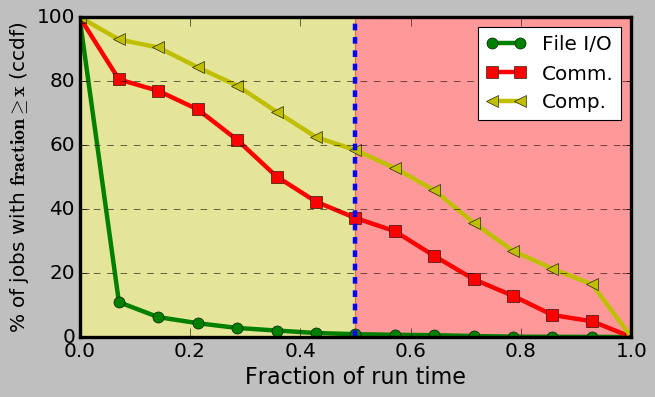

In [105]:
def run_time_break(ap_df, ds_df):
    io_time_key = ['TOTAL_CP_F_POSIX_READ_TIME', 'TOTAL_CP_F_POSIX_WRITE_TIME', 'TOTAL_CP_F_POSIX_META_TIME', \
                   'TOTAL_CP_F_MPI_META_TIME', 'TOTAL_CP_F_MPI_READ_TIME', 'TOTAL_CP_F_MPI_WRITE_TIME']
    ap_jid_sarg = np.argsort(ap_df.zero_batchJobId)
    ds_jid_sarg = np.argsort(ds_df.COBALT_JOBID)
#     print((ap_df.zero_batchJobId.values[ap_jid_sarg] - ds_df.COBALT_JOBID.values[ds_jid_sarg]).sum() )
    cul_io_time  = (ds_df[io_time_key].values.sum(axis=1))[ds_jid_sarg]
    cul_mpi_time = (ap_df.zero_stdMpiTime.values  * ap_df.zero_numRanks.values)[ap_jid_sarg]
    cul_run_time = (ap_df.zero_elapsedTime.values * ap_df.zero_numRanks.values)[ap_jid_sarg]
#     cul_run_time = (ds_df.RUN_TIME.values * ds_df.NPROCS.values)[ds_jid_sarg]
    
    frac_io   = cul_io_time / cul_run_time
    frac_mpi  = cul_mpi_time / cul_run_time
    frac_comp = 1 - frac_io - frac_mpi
    mask = (frac_io>=0) & (frac_io<=1) & (frac_mpi>=0) & (frac_mpi<=1) & (frac_comp>=0) & (frac_comp<=1)
#     print(frac_comp.min(), frac_comp.max(), np.sum(frac_comp<0))
    return frac_io[mask], frac_mpi[mask], frac_comp[mask]
    
def cdf_run_time_break(signals, nbins=15, ofn=None):
    ax = new_fig()
#     lgd = ('File I/O', 'Comm.', 'Comp.')
    lgd = ('File I/O', 'Communication', 'Computation')
    colors, markers = ('g', 'r', 'y'), ('-o', '-s', '-<')
    bins = np.linspace(0, 1, nbins)
    for idx, data in enumerate(signals):
        cnt  = [(data<bf).sum() for bf in bins]
        norm = np.array(cnt) / data.shape[0] * 100
#         print(np.median(data))
        plt.plot(bins, norm, markers[idx],linewidth=4, markersize=10,\
                 label=lgd[idx], color=colors[idx], )
    plt.ylabel('Cumulative percentage of jobs', fontsize=20)
    plt.xlim(left=0, right=1)
    plt.xlabel('Fraction of run time', fontsize=20)
    plt.legend(fontsize=18, loc=0, ncol=1)
    plt.plot((0.5, 0.5), (norm.min(), norm.max()), '--', linewidth=4)
    plt.fill_between((0, 0.5), (100, 100), color='y', alpha=.4)
    plt.fill_between((0.5, 1), (100, 100), color='r', alpha=.4)
    if ofn is not None:
        plt.savefig('../figure/' + ofn, bbox_inches='tight')
    plt.show()
    
def ccdf_run_time_break(signals, nbins=15, ofn=None):
    ax = new_fig()
    lgd = ('File I/O', 'Comm.', 'Comp.')
    colors, markers = ('g', 'r', 'y'), ('-o', '-s', '-<')
    bins = np.linspace(0, 1, nbins)
    for idx, data in enumerate(signals):
        cnt  = [(data<bf).sum() for bf in bins]
        norm = np.array(cnt) / data.shape[0] * 100
#         print(np.median(data))
        plt.plot(bins, 100.-norm, markers[idx],linewidth=4, markersize=10,\
                 label=lgd[idx], color=colors[idx], )
    plt.ylabel('% of jobs with $\mathbf{fraction \geq x}$ (ccdf)', fontsize=18)
    plt.xlim(left=0, right=1)
    plt.xlabel('Fraction of run time', fontsize=20)
    plt.legend(fontsize=18, loc=0, ncol=1)
    plt.plot((0.5, 0.5), (norm.min(), norm.max()), '--', linewidth=4)
    plt.fill_between((0, 0.5), (100, 100), color='y', alpha=.4)
    plt.fill_between((0.5, 1), (100, 100), color='r', alpha=.4)
    if ofn is not None:
        plt.savefig('../figure/' + ofn, bbox_inches='tight')
    plt.show()
    
ccdf_run_time_break((frac_io, frac_mpi, frac_comp), nbins=15, ofn='ccdf-run-time-breakdown.pdf')

-3.0393804057497507 0.9999999305961151 20392


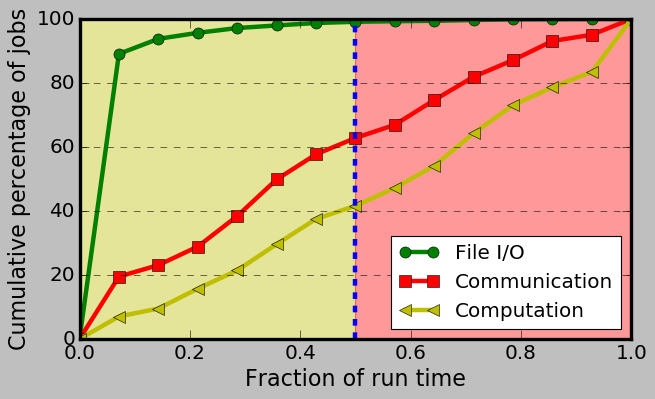

In [106]:
frac_io, frac_mpi, frac_comp = run_time_break_raw(ap_join_df, ds_join_df)
cdf_run_time_break((frac_io, frac_mpi, frac_comp), nbins=15, ofn='cdf-run-time-breakdown.pdf')

In [107]:
line_cnt = 0
fdo = open('../data/ap-ds-join/cmb-ap-1802-1812.csv', 'w')
for i, fn in enumerate(glob.glob('../data/ap-ds-join/ap*')[:]):
    lines = open(fn).readlines()
    line_cnt += len(lines) - 1
    if i == 0: 
        fdo.write(''.join(lines))
    else:
        fdo.write(''.join(lines[1:]))
#     fd.close()
fdo.close()

In [108]:
line_cnt = 0
fdo = open('../data/ap-ds-join/cmb-ds-1802-1812.csv', 'w')
for i, fn in enumerate(glob.glob('../data/ap-ds-join/ds*')[:]):
    lines = open(fn).readlines()
    line_cnt += len(lines) - 1
    if i == 0: 
        fdo.write(''.join(lines))
    else:
        fdo.write(''.join(lines[1:]))
#     fd.close()
fdo.close()

In [109]:
darshan18  = pd.read_csv('../data/ap-ds-join/cmb-ds-1802-1812.csv')
autoperf18 = pd.read_csv('../data/ap-ds-join/cmb-ap-1802-1812.csv')
# task18 = pd.read_csv('datasets/task-his/ANL-ALCF-TH-MIRA_20180101_20181231.csv')
darshan18.shape, autoperf18.shape

((10155, 174), (10155, 1057))

In [110]:
posix_meta_time = darshan18.TOTAL_CP_F_POSIX_META_TIME
posix_io_time   = darshan18.TOTAL_CP_F_POSIX_META_TIME + darshan18.TOTAL_CP_F_POSIX_READ_TIME + darshan18.TOTAL_CP_F_POSIX_WRITE_TIME
posix_io_mask   = posix_meta_time > 0
posix_meta_ops_frac = posix_meta_time[posix_io_mask] / posix_io_time[posix_io_mask]

mpi_meta_time = darshan18.TOTAL_CP_F_MPI_META_TIME
mpi_io_time   = darshan18.TOTAL_CP_F_MPI_META_TIME + darshan18.TOTAL_CP_F_MPI_READ_TIME + darshan18.TOTAL_CP_F_MPI_WRITE_TIME
mpiio_mask = mpi_meta_time > 0
mpiio_meta_ops_frac = mpi_meta_time[mpiio_mask] / mpi_io_time[mpiio_mask]

In [111]:
posix_meta_ops_frac.shape[0], mpiio_meta_ops_frac.shape[0], np.sum(posix_io_mask & mpiio_mask), darshan18.shape

(10129, 5317, 5317, (10155, 174))

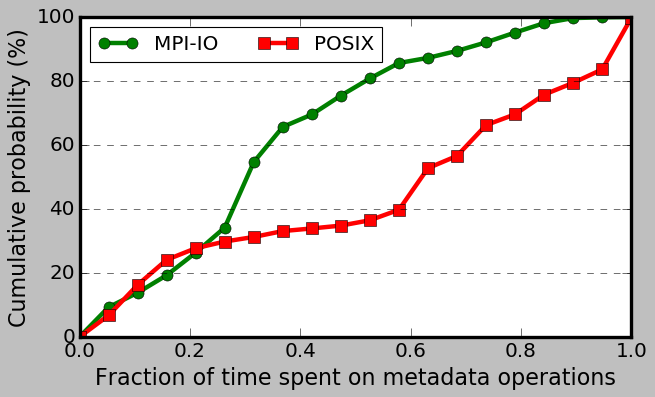

In [112]:
def cdf_meta_time_cmb(data_mpiio_posix, nbins=15, ofn=None):
    ax = new_fig()
    lgd = ('MPI-IO', 'POSIX')
    colors, markers = ('g', 'r'), ('-o', '-s')
    bins = np.linspace(0, 1, nbins)
    for idx, data in enumerate(data_mpiio_posix):
        cnt  = [(data<bf).sum() for bf in bins]
        norm = np.array(cnt) / data.shape[0] * 100
#         print(np.median(data))
        plt.plot(bins, norm, markers[idx],linewidth=4, markersize=10,\
                 label=lgd[idx], color=colors[idx], )
    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlim(left=0, right=1)
    plt.xlabel('Fraction of time spent on metadata operations', fontsize=20)
    plt.legend(fontsize=18, loc=0, ncol=2)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight')
    plt.show()
    
cdf_meta_time_cmb(data_mpiio_posix=(mpiio_meta_ops_frac, posix_meta_ops_frac), \
                  nbins=20, ofn=None)

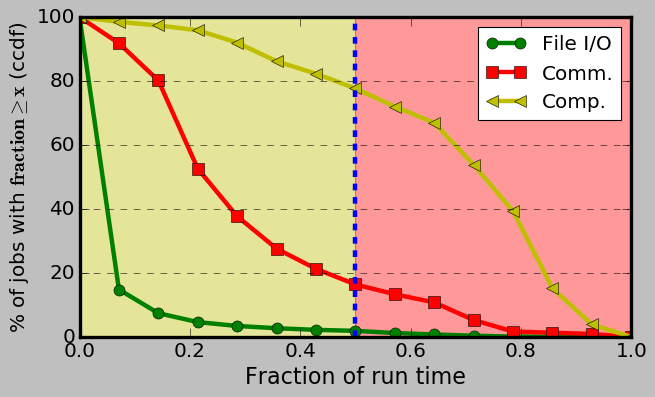

In [113]:
frac_io, frac_mpi, frac_comp = run_time_break(autoperf18, darshan18)
# cdf_run_time_break((frac_io, frac_mpi, frac_comp), nbins=15, ofn='run-time-break.pdf')
ccdf_run_time_break((frac_io, frac_mpi, frac_comp), nbins=15, ofn='ccdf-run-time-break.pdf')